In [2]:
import torch.nn.functional as F
from torch import nn
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import math

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 

def linear_beta_schedule(timesteps, start=0.0001, end=0.02):
    return torch.linspace(start, end, timesteps)

def root_beta_schedule(timesteps, start=0.0001, end=0.02):
    

# Define beta schedule
T = 200
betas = linear_beta_schedule(timesteps=T)

# Pre-calculate different terms for closed form
alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, axis=0)
sqrt_recip_alphas = torch.sqrt(1.0/ alphas)
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)

In [6]:
IMG_SIZE = 64
BATCH_SIZE = 128

def load_transformed_dataset():
    data_transforms = [
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(), # Scales data into [0, 1]
        transforms.Lambda(lambda t: (t * 2) - 1) # Scale between [-1, 1]
    ]

    data_transform = transforms.Compose(data_transforms)

    train = torchvision.datasets.FGVCAircraft(root=".", download=True, transform=data_transform)

    test = torchvision.datasets.FGVCAircraft(root=".", download=True, transform=data_transform, split='test')

    return torch.utils.data.ConcatDataset([train, test])

def show_tensor_image(image):
    reverse_transforms = transforms.Compose([
        transforms.Lambda(lambda t: (t + 1) / 2),
        transforms.Lambda(lambda t: t.permute(1, 2, 0)), # CHW to HWC
        transforms.Lambda(lambda t: t * 255.),
        transforms.Lambda(lambda t: t.numpy().astype(np.uint8)),
        transforms.ToPILImage(),
    ])

    # take first image of batch
    if len(image.shape) == 4:
        image = image[0, :, :, :]
    plt.imshow(reverse_transforms(image))

data = load_transformed_dataset()
dataloader = DataLoader(data, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)


In [19]:
def forward_diffusion_sample(image, t):
    noise = torch.randn(3, 64, 64)
    image_noised = (sqrt_alphas_cumprod[t] * image) + (sqrt_one_minus_alphas_cumprod[t] * noise)
    return image_noised, noise

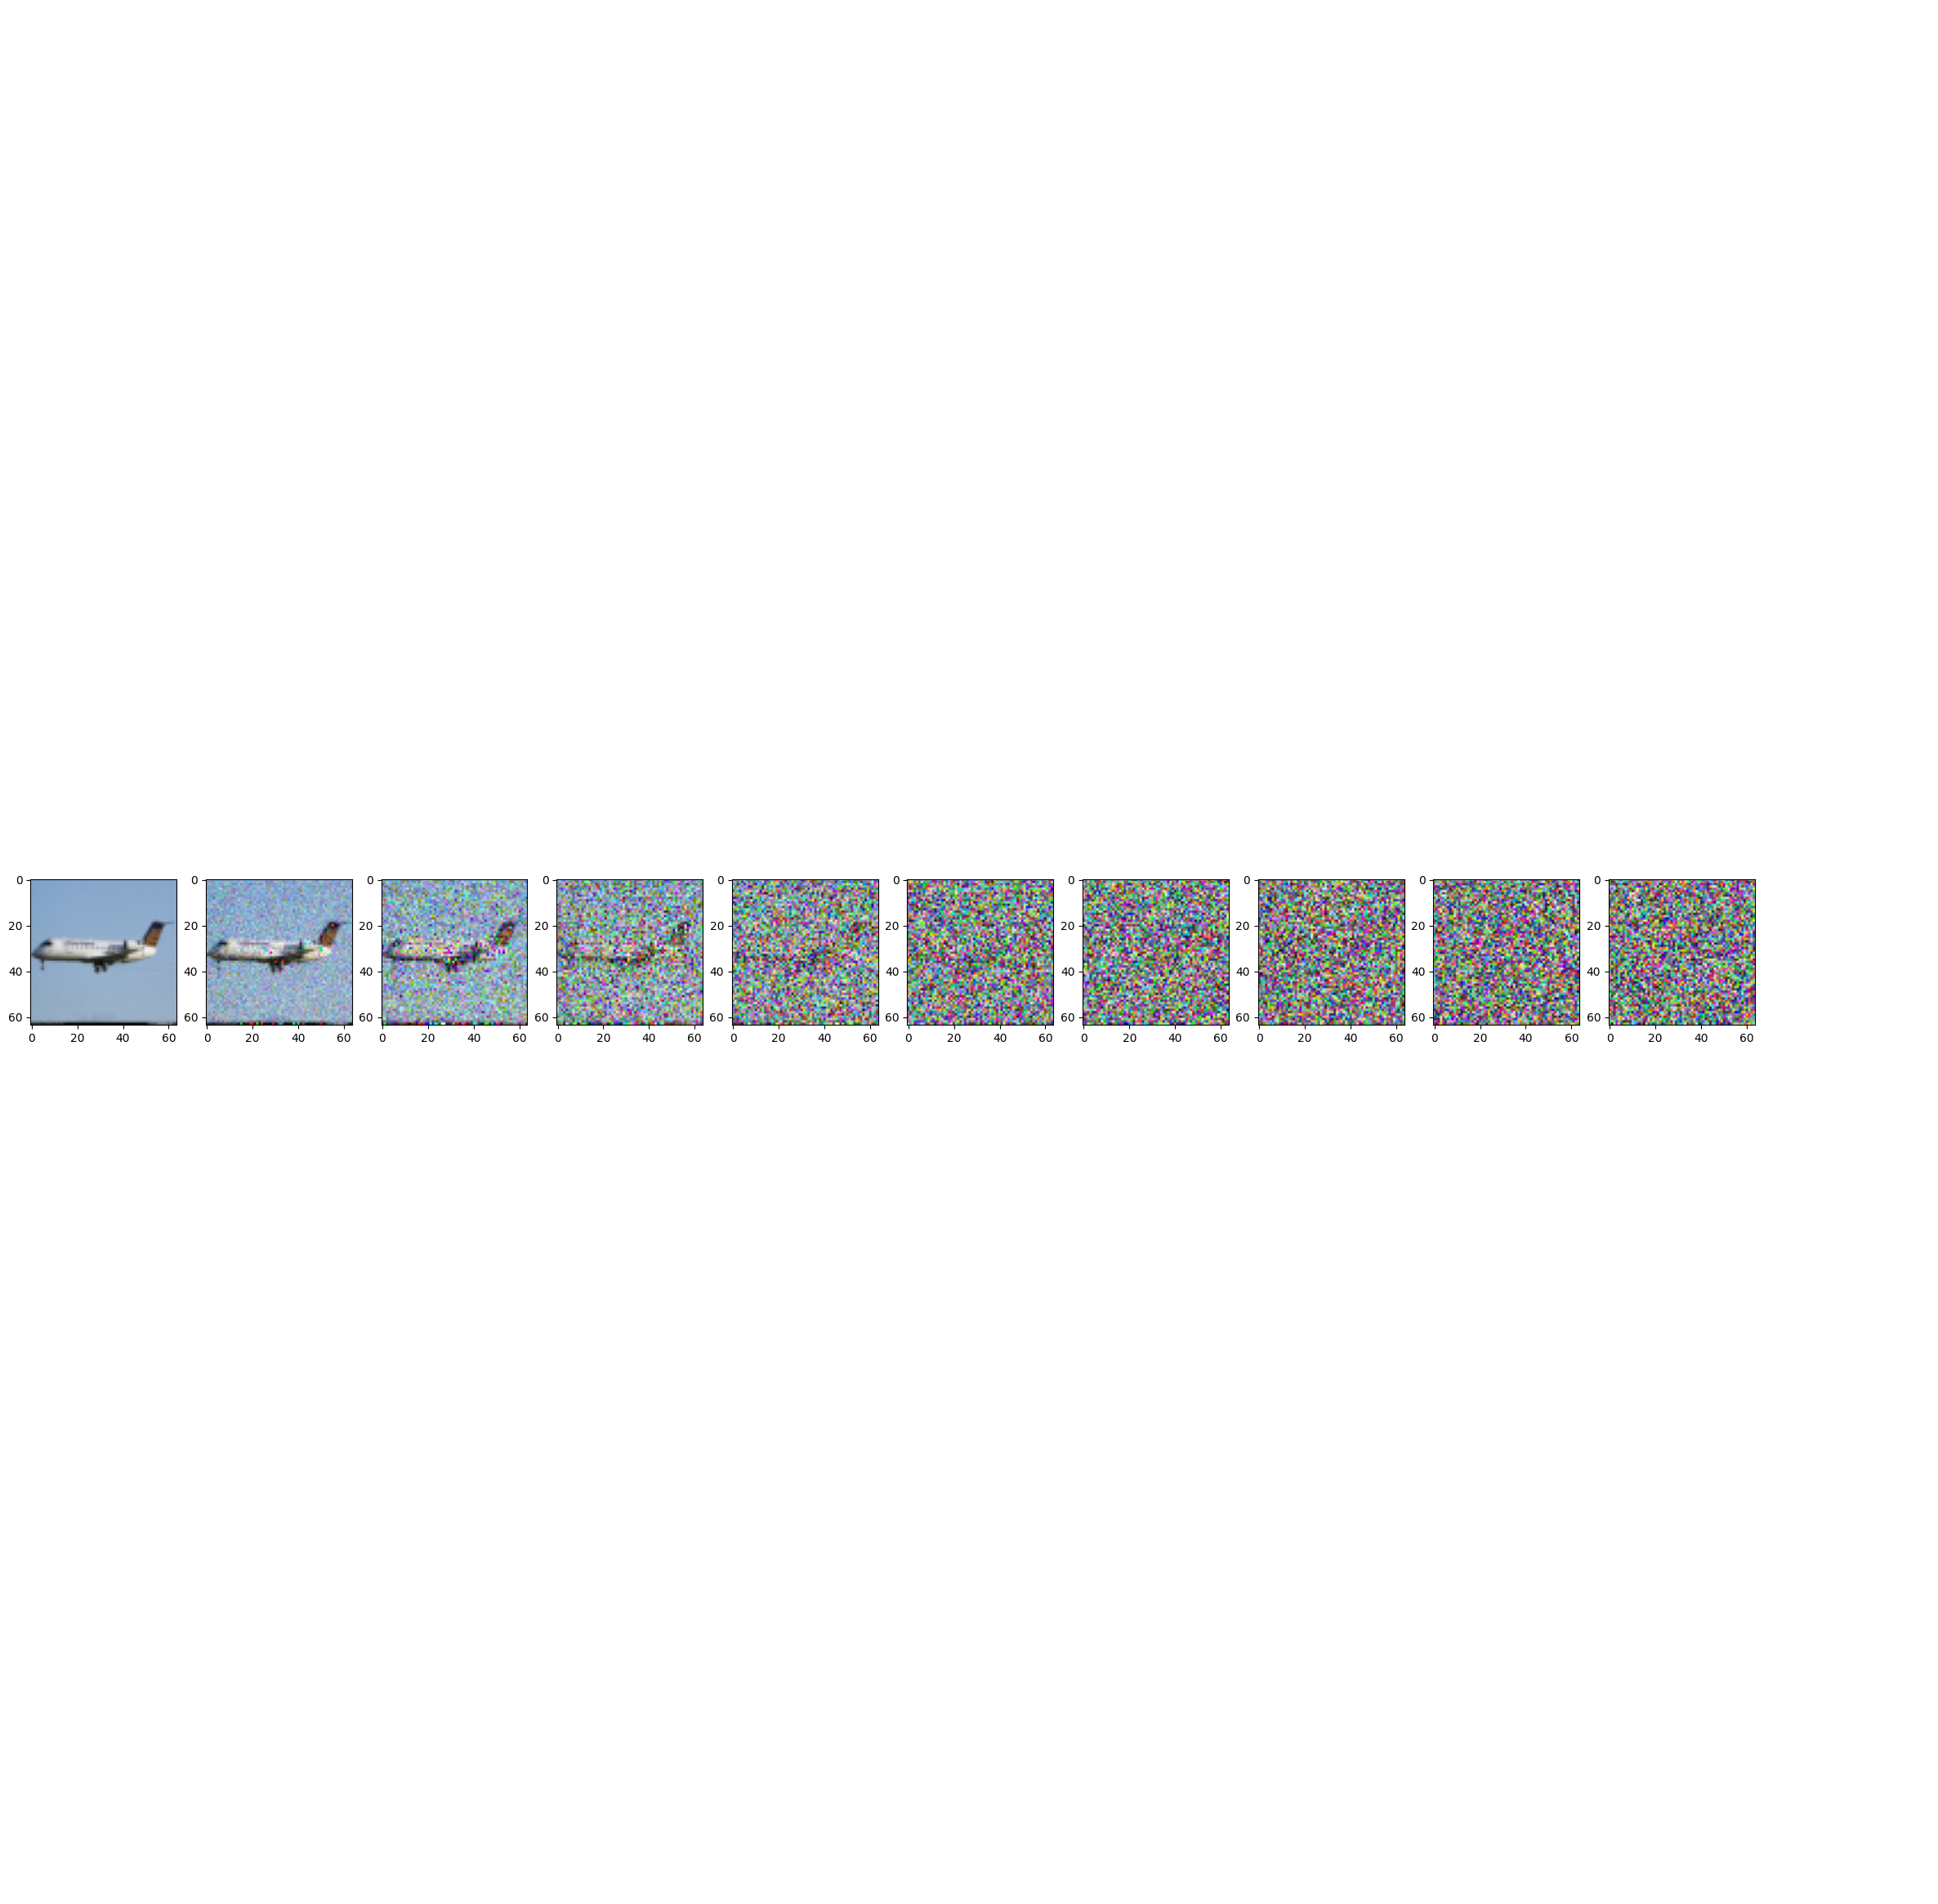

In [25]:
# Simulate forward diffusion
image = next(iter(dataloader))[0]

plt.figure(figsize=(30,30))
plt.axis('off')
num_images = 10
stepsize = int(T/num_images)

for idx in range(0, T, stepsize):
    t = torch.Tensor([idx]).type(torch.int64)
    plt.subplot(1, num_images+1, int(idx/stepsize) + 1)
    img, noise = forward_diffusion_sample(image, t)
    show_tensor_image(img)

In [37]:
# Training algorithm
# x_0 ~ q(x_0)
# t ~ Uniform({1, ...., T})
# eps ~ N(0, I)
# Take graident descent step on MSE(eps - eps_theta(root(alpha_t_bar)*x_0 + root(1-alpha_t_bar)*eps, t))
# Until converged

# Sampling algorithm
# for t = T, ... t do
# z ~ N(0, I) if t > 1, else z =0
# x_t-1 = 1/root(alpha_t) * (x_t - (1-alpha_t)/(root(1-alpha_t))*eps_theta(x_t, t)) + sigma_t*z
# end for
# return x_0
